# This Notebook is for downloading Sentinwel-2 images using a polygon area

# 1-Loading Libraries

In [30]:
%%capture
# Suppress output during the installation process

import subprocess, sys

packages = ["rasterio", "pycrs", "xee", "netCDF4"]

for pkg in packages:
    print(f"Installing {pkg} ...", end=" ")
    result = subprocess.run(
        [sys.executable, "-m", "pip", "install", "-q", pkg],
        capture_output=True,
        text=True
    )

    if result.returncode == 0:
        print("OK")
    else:
        print("failed")
        print(result.stderr)


In [31]:
#need update it
import subprocess, sys
from importlib import metadata

def pip_upgrade(pkg):
    print(f"Updating {pkg} ...", end=" ")
    r = subprocess.run(
        [sys.executable, "-m", "pip", "install", "--upgrade", "-q", pkg],
        capture_output=True,
        text=True
    )
    if r.returncode == 0:
        print("done")
        try:
            print(f"{pkg} installed version: {metadata.version(pkg)}")
        except metadata.PackageNotFoundError:
            print(f"{pkg} installed, but version not found in metadata.")
    else:
        print("failed")
        print(r.stderr)

pip_upgrade("geemap")



Updating geemap ... done
geemap installed version: 0.37.1


In [32]:
import ee
print('ee version: ' + ee.__version__)
from datetime import datetime
import time
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
print('geopandas version: ' + gpd.__version__)
import pandas as pd
print('pandas version: ' + pd.__version__)

import geemap
print('geemap version: ' + geemap.__version__)

import rasterio
print('rasterio version: ' + rasterio.__version__)
import matplotlib.pyplot as plt
import numpy as np
import pycrs
import xee
import xarray as xr

print('xarray version: ' + xr.__version__)
import tensorflow as tf
print('Tensorflow version: ' + tf.__version__)

import folium
print('Folium version: ' + folium.__version__)
import netCDF4

ee version: 1.7.14
geopandas version: 1.1.2
pandas version: 2.2.2
geemap version: 0.37.1
rasterio version: 1.5.0
xarray version: 2025.12.0
Tensorflow version: 2.19.0
Folium version: 0.20.0


In [33]:
# Trigger the authentication flow.
import ee
ee.Authenticate(force=True)
ee.Initialize(project="geesatellites")

# 2-Get access to Drive anf GEE

In [34]:

# Trigger the authentication flow.
ee.Authenticate()
# Check the user and initialize Earth Engine accordingly
user = "Carlos"  # Replace with the actual logic to determine the user

if user == "Carlos":
    ee.Initialize(project='geesatellites',opt_url='https://earthengine-highvolume.googleapis.com')
else:
    ee.Initialize(project='xxx', opt_url='https://earthengine-highvolume.googleapis.com')



In [35]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3-Main functions

In [36]:
def get_all_images(start_date, end_date, rectangle, cloud_percentage,collection):
    """
    Filter the Sentinel-2 L2A image collection based on the specified criteria for the given period.

    Args:
    start_date (str): Start date in 'YYYY-MM-DD' format.
    end_date (str): End date in 'YYYY-MM-DD' format.
    rectangle (ee.Geometry.Rectangle): The rectangle for spatial filtering.
    cloud_percentage: percentage of clouds in %
    collection (srt): -S2_SR_HARMONIZED or S2_SR
    satellite (srt): Sentinel-2A 0r Sentinel-2B
    Returns:
    ee.ImageCollection: The filtered image collection.
    """

    # Define the Sentinel-2 image collection based on the input type.
    if collection == "SR":
        #https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR
        sentinel_collection = ee.ImageCollection("COPERNICUS/S2_SR")
        bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12','SCL']
    elif collection == "SR_HARMONIZED":
        #https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED
        sentinel_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
          # Select bands for reflectance calculation
        bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12','SCL']
    else:
        raise ValueError("Invalid collection type. Supported types: 'SR' or 'SR_HARMONIZED'.")


    # Apply the temporal and spatial filters.
    filtered_collection = sentinel_collection.filterDate(ee.Date(start_date), ee.Date(end_date)).filterBounds(rectangle)
    filtered_collection = filtered_collection.filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", cloud_percentage)
    filtered_collection = filtered_collection.select(bands)

    return filtered_collection

# 4-Get SE2 collections

In [37]:
# Define the path to the shapefile in Google Drive
shapefile_path = '/content/drive/My Drive/0-JRC_studies/HYDRA-EO/Orchards/Alfalfa_site2.shp'

# Load the shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Convert the geopandas GeoDataFrame to an Earth Engine FeatureCollection
ee_shape = geemap.geopandas_to_ee(gdf)

# Print information about the FeatureCollection
print("Number of features in the shapefile:", ee_shape.size().getInfo())
print("First five features:", ee_shape.limit(5).getInfo())

Number of features in the shapefile: 1
First five features: {'type': 'FeatureCollection', 'columns': {'id': 'Integer', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[10.738267162298383, 44.72453079862733], [10.738528589400534, 44.6936630052526], [10.803231797182969, 44.6940692479528], [10.802708942978667, 44.724327765096476], [10.738267162298383, 44.72453079862733]]]}, 'id': '0', 'properties': {'id': 1}}]}


In [38]:
# Get the region of interest (ROI) as a rectangle
roi = ee_shape.geometry().bounds()
geometry = ee_shape.geometry()

In [39]:
# Get the region of interest (ROI) as a rectangle
roi = ee_shape.geometry().bounds()
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Geometry.bounds",
    "arguments": {
      "geometry": {
        "functionInvocationValue": {
          "functionName": "Collection.geometry",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection",
                "arguments": {
                  "features": {
                    "arrayValue": {
                      "values": [
                        {
                          "functionInvocationValue": {
                            "functionName": "Feature",
                            "arguments": {
                              "geometry": {
                                "functionInvocationValue": {
                                  "functionName": "GeometryConstructors.Polygon",
                                  "arguments": {
                                    "coordinates": {
                                      "constantValue": [
                                        [
                                          [
                                            10.738267162298383,
                                            44.72453079862733
                                          ],
                                          [
                                            10.802708942978667,
                                            44.724327765096476
                                          ],
                                          [
                                            10.803231797182969,
                                            44.6940692479528
                                          ],
                                          [
                                            10.738528589400534,
                                            44.6936630052526
                                          ],
                                          [
                                            10.738267162298383,
                                            44.72453079862733
                                          ]
                                        ]
                                      ]
                                    },
                                    "geodesic": {
                                      "constantValue": true
                                    }
                                  }
                                }
                              },
                              "metadata": {
                                "constantValue": {
                                  "id": 1
                                }
                              }
                            }
                          }
                        }
                      ]
                    }
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [40]:
# tu ROI (polígono)
roi = ee_shape.geometry()

# bounding box
bbox = roi.bounds()

# convertir a lista de coordenadas
coords = bbox.coordinates().getInfo()[0]

# extraer extremos
xmin = coords[0][0]
ymin = coords[0][1]
xmax = coords[2][0]
ymax = coords[2][1]

print(xmin, ymin, xmax, ymax)

10.738267162298383 44.693663005252574 10.803231797182967 44.724530798627356


In [41]:
rectangle = ee.Geometry.Rectangle([xmin, ymin, xmax, ymax])
print(rectangle.getInfo())

{'type': 'Polygon', 'coordinates': [[[10.738267162298383, 44.693663005252574], [10.803231797182967, 44.693663005252574], [10.803231797182967, 44.724530798627356], [10.738267162298383, 44.724530798627356], [10.738267162298383, 44.693663005252574]]]}


In [42]:
# List of image collections
image_collections = [
    get_all_images('2022-01-01', '2022-12-31', rectangle, cloud_percentage=85, collection='SR_HARMONIZED'),
    get_all_images('2023-01-01', '2023-12-31', rectangle, cloud_percentage=85, collection='SR_HARMONIZED'),
    get_all_images('2024-01-01', '2024-12-31', rectangle, cloud_percentage=85, collection='SR_HARMONIZED'),
    get_all_images('2025-01-01', '2025-12-31', rectangle, cloud_percentage=85, collection='SR_HARMONIZED')]

In [43]:
image_collections[0]

Output hidden; open in https://colab.research.google.com to view.

In [44]:
# Convert the image collection to a list
images= image_collections[0].toList(image_collections[0].size())
images

Output hidden; open in https://colab.research.google.com to view.

In [45]:
# Get the first image in the collection to retrieve the projection information
projection = image_collections[0].first().select(0).projection().getInfo()
print(projection)


{'type': 'Projection', 'crs': 'EPSG:32632', 'transform': [10, 0, 600000, 0, -10, 5000040]}


## 4.1 get SE2 optical and viewing properties

Take a picture of the viewing angles https://sacs.aeronomie.be/info/sza.php, then upload to google drive for understanding the viewing angles

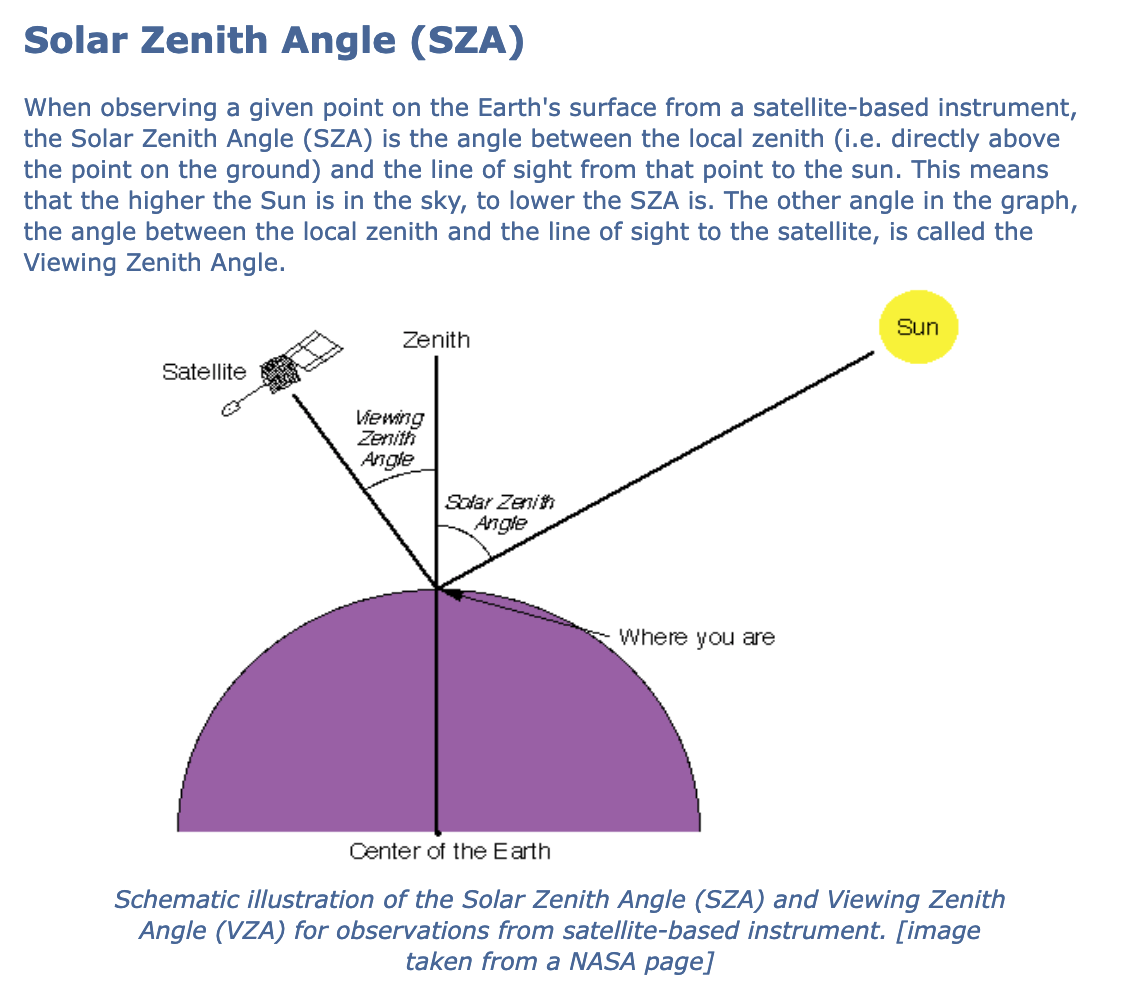

In [46]:
from IPython.display import Image

# Define the path to the image
image_path = '/content/drive/My Drive/0-GEE-projects/png-files/viewing_angles.png'

# Display the image
display(Image(filename=image_path, width=500, height=300))

In [47]:


# Iterate over each image in the collection
for collection_index in range(len(image_collections)):

    current_collection = image_collections[collection_index]
    #Create a list to store the extracted properties
    output_list = []

    for image in current_collection.toList(current_collection.size()).getInfo():
      properties = image['properties']
      sensor = properties['SPACECRAFT_NAME']
      # Extract the date from the properties
      timestamp_milliseconds = properties['GENERATION_TIME']
      # Convert the timestamp to a human-readable date
      date = datetime.utcfromtimestamp(timestamp_milliseconds / 1000).strftime('%Y-%m-%d %H:%M:%S')
      # Extract the year from the date
      year = datetime.strptime(date, '%Y-%m-%d %H:%M:%S').year
      #print(f'Date: {date}')
      # Extract MEAN_INCIDENCE_ZENITH for averaging
      mean_incident_zenith_angles = [
          properties['MEAN_INCIDENCE_ZENITH_ANGLE_B2'], properties['MEAN_INCIDENCE_ZENITH_ANGLE_B3'], properties['MEAN_INCIDENCE_ZENITH_ANGLE_B4'],
          properties['MEAN_INCIDENCE_ZENITH_ANGLE_B5'],properties['MEAN_INCIDENCE_ZENITH_ANGLE_B6'], properties['MEAN_INCIDENCE_ZENITH_ANGLE_B7'],
          properties['MEAN_INCIDENCE_ZENITH_ANGLE_B8'], properties['MEAN_INCIDENCE_ZENITH_ANGLE_B8A'],properties['MEAN_INCIDENCE_ZENITH_ANGLE_B11'],
          properties['MEAN_INCIDENCE_ZENITH_ANGLE_B12'],]
      # Calculate the average
      average_incident_zenith = sum(mean_incident_zenith_angles) / len(mean_incident_zenith_angles)
      #print(f'Average Incident Angle: {average_incident_zenith}')

      #Extract MEAN_INCIDENCE_AZIMUTH_ANGLE for averaging
      mean_incident_azimuth_angles = [
          properties['MEAN_INCIDENCE_AZIMUTH_ANGLE_B2'],properties['MEAN_INCIDENCE_AZIMUTH_ANGLE_B3'],properties['MEAN_INCIDENCE_AZIMUTH_ANGLE_B4'],
          properties['MEAN_INCIDENCE_AZIMUTH_ANGLE_B5'],properties['MEAN_INCIDENCE_AZIMUTH_ANGLE_B6'],properties['MEAN_INCIDENCE_AZIMUTH_ANGLE_B7'],
          properties['MEAN_INCIDENCE_AZIMUTH_ANGLE_B8'],properties['MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A'],properties['MEAN_INCIDENCE_AZIMUTH_ANGLE_B11'],
          properties['MEAN_INCIDENCE_AZIMUTH_ANGLE_B12'],]

      # Calculate the average
      average_incident_azimuth = sum(mean_incident_azimuth_angles) / len(mean_incident_azimuth_angles)

      #Extract  SOLAR_IRRADIANCE for averaging (SCOPE model)
      solar_irradiance = [
          properties['SOLAR_IRRADIANCE_B1'], properties['SOLAR_IRRADIANCE_B2'], properties['SOLAR_IRRADIANCE_B3'],
          properties['SOLAR_IRRADIANCE_B4'],properties['SOLAR_IRRADIANCE_B5'],properties['SOLAR_IRRADIANCE_B6'],
          properties['SOLAR_IRRADIANCE_B7'],properties['SOLAR_IRRADIANCE_B8'],properties['SOLAR_IRRADIANCE_B8A'],
          properties['SOLAR_IRRADIANCE_B9'],properties['SOLAR_IRRADIANCE_B10'],properties['SOLAR_IRRADIANCE_B11']]
      # Extract desired properties
      mean_solar_azimuth = properties['MEAN_SOLAR_AZIMUTH_ANGLE']
      mean_solar_zenith = properties['MEAN_SOLAR_ZENITH_ANGLE']

      #Add values to the output list
      output_list.append([date, sensor,mean_solar_azimuth, mean_solar_zenith, average_incident_zenith, average_incident_azimuth] + solar_irradiance)

    # Convert output_list to pandas DataFrame
    df = pd.DataFrame(output_list, columns=['Date', 'Sensor', 'Solar Azimuth', 'Solar Zenith','incident_zenith','incident_azimuth'] + [f'Solar_irradiance_B{i}' for i in range(1, 13)])
    # Save the DataFrame to a CSV file
    csv_filename = '/content/drive/My Drive/0-JRC_studies/HYDRA-EO/properties/Sentinel-'+str(year)+'-properties_Alfalfa_site2.csv'
    df.to_csv(csv_filename, index=False)
    print(f'CSV file for "{year}" created successfully.')





CSV file for "2022" created successfully.
CSV file for "2023" created successfully.
CSV file for "2024" created successfully.
CSV file for "2025" created successfully.


In [48]:
df.head()

,Date,Sensor,Solar Azimuth,Solar Zenith,incident_zenith,incident_azimuth,Solar_irradiance_B1,Solar_irradiance_B2,Solar_irradiance_B3,Solar_irradiance_B4,Solar_irradiance_B5,Solar_irradiance_B6,Solar_irradiance_B7,Solar_irradiance_B8,Solar_irradiance_B9,Solar_irradiance_B10,Solar_irradiance_B11,Solar_irradiance_B12
0,2025-01-02 13:43:46,Sentinel-2A,164.749570,68.978653,3.602545,121.546236,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59
1,2025-01-10 13:07:12,Sentinel-2B,166.125271,67.719366,9.952082,286.656767,1874.30,1959.75,1824.93,1512.79,1425.78,1291.13,1175.57,1041.28,953.93,817.58,365.41,247.08
2,2025-01-12 12:24:49,Sentinel-2A,163.407374,67.911828,3.652005,119.918906,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59
3,2025-01-15 14:27:51,Sentinel-2A,165.482945,66.967683,9.953293,287.368978,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59
4,2025-01-17 15:44:07,Sentinel-2B,162.760271,67.107065,3.645929,121.219687,1874.30,1959.75,1824.93,1512.79,1425.78,1291.13,1175.57,1041.28,953.93,817.58,365.41,247.08


## 3.1 Get the Xarray

In [49]:
SE2_images = image_collections[0]
SE2_images

Output hidden; open in https://colab.research.google.com to view.

In [50]:
 ds = xr.open_dataset(
         image_collections[0],
        engine='ee',
        #crs= 'EPSG:32632',
        projection=SE2_images.first().select(0).projection().crs(),
        geometry=rectangle
    )

In [51]:
projection = SE2_images.first().select(0).projection()
print("CRS:", projection.crs().getInfo())

CRS: EPSG:32632


In [52]:
import warnings
# Select bands for reflectance calculation
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'SCL']

# Assuming `image_collections` is a list of image elements
for SE2_images in image_collections:
    # Open each image element as a dataset
    ds = xr.open_dataset(
        SE2_images.select(bands),
        engine='ee',
        #crs= 'EPSG:32632',
       projection=SE2_images.first().select(0).projection().crs(),
        geometry=rectangle
    )
    time = (ds['time'].values[0])
    print(time)
     # Convert the time value to pandas datetime object
    time_pd = pd.to_datetime(time)

    # Extract the year from the datetime object
    year = time_pd.year
    # Print the extracted year
    print(year)
    # Rename the dimensions
    #ds = ds.rename({'X': 'x', 'Y': 'y'})
    # Define the output name including the year
    out_name = f'/content/drive/My Drive/0-JRC_studies/HYDRA-EO/Lelystad_/{year}_gee_SR.nc'

    ##### remove this #################################################################
    ## Set _FillValue for variables with floating-point data
    ##for variable in ds.variables:
    #####print(variable)
    ### if variable not in ['SCL', 'time', 'x', 'y'] and ds[variable].dtype.kind == 'f':
    ####### ds[variable] = ds[variable].astype('float32', copy=False)
    ####### ds[variable].encoding['_FillValue'] = None
    ###########################################################################

    # Save the dataset to NetCDF with the specified output name, suppressing SerializationWarning
    with warnings.catch_warnings():
      warnings.simplefilter("ignore", category=xr.SerializationWarning)
      if year == 2018:
        # this is an example only write in Drive 2018
        #ds.to_netcdf(out_name)
        print(ds)


2022-01-01T10:28:26.175000000
2022
2023-01-06T10:28:23.379000000
2023
2024-01-03T10:18:28.917000000
2024
2025-01-02T10:18:28.311000000
2025


In [53]:
ds

<xarray.Dataset> Size: 113GB
Dimensions:  (time: 139, lon: 5221, lat: 3541)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2025-01-02T10:18:28.311000 ... 2025-12...
  * lon      (lon) float64 42kB 6.377e+05 6.377e+05 ... 6.429e+05 6.429e+05
  * lat      (lat) float64 28kB 4.95e+06 4.95e+06 ... 4.954e+06 4.954e+06
Data variables:
    B2       (time, lon, lat) float32 10GB ...
    B3       (time, lon, lat) float32 10GB ...
    B4       (time, lon, lat) float32 10GB ...
    B5       (time, lon, lat) float32 10GB ...
    B6       (time, lon, lat) float32 10GB ...
    B7       (time, lon, lat) float32 10GB ...
    B8       (time, lon, lat) float32 10GB ...
    B8A      (time, lon, lat) float32 10GB ...
    B11      (time, lon, lat) float32 10GB ...
    B12      (time, lon, lat) float32 10GB ...
    SCL      (time, lon, lat) float32 10GB ...
Attributes: (12/18)
    date_range:             [1490659200000, 1647907200000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'reflectance',...
    period:                 0
    product_tags:           ['msi', 'sr', 'reflectance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name:   RGB
    crs:                    EPSG:4326

In [54]:
# This is for working in python
ds = ds.transpose('time', 'lat', 'lon')  # Adjust dimensions as needed


2025-01-02T10:18:28.311000000


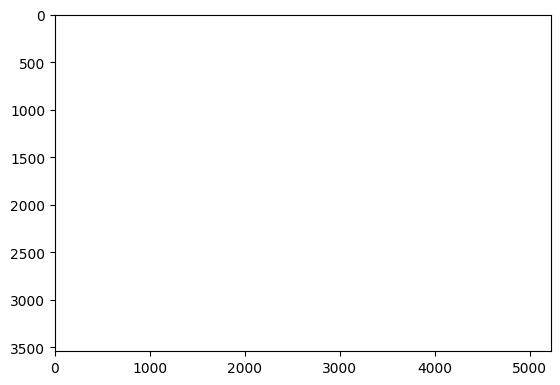

In [55]:
# Plot the RGB image
print(ds['time'].values[0])
# Specify the desired date (replace '2020-01-23' with the desired date)
selected_date = ds['time'].values[0]

# Select the image for the specified date
selected_image = ds.sel(time=selected_date)
# Plot the RGB image
plt.imshow(selected_image['B2'])
plt.show()

# 5-Plot the Sentinel-2 Collection

In [56]:
# Get one image
image = ee.Image(images.get(0))

# Crop the image to the specified rectangle
cropped_image = image.clip(rectangle)


In [57]:
# Print it in map
Map = geemap.Map(width=800, height=400)
Map.centerObject(rectangle, zoom=14)
Map.addLayer(cropped_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'RGB')
#Map.addLayer(cropped_image, {'bands': ['SCL'], 'min': 0, 'max': 11}, 'SCL')
Map.addLayer(rectangle, {}, 'Rectangle')
Map.addLayerControl()
Map

Map(center=[44.70910013362995, 10.770749479741987], controls=(WidgetControl(options=['position', 'transparent_…

In [58]:
import numpy as np
import matplotlib.pyplot as plt

t0 = ds.time.values[0]
da = ds["B2"].sel(time=t0).transpose("lat","lon")  # asegúrate 2D en este orden

arr = da.values
print("B2 shape:", arr.shape, "finite px:", np.isfinite(arr).sum(), "min/max:", np.nanmin(arr), np.nanmax(arr))

B2 shape: (3541, 5221) finite px: 0 min/max: nan nan


# 6-Get individual GeoTiFF

In [59]:
# Output folder path


output_folder = '/content/drive/My Drive/0-JRC_studies/HYDRA-EO/SeriesTiFFs_Alfalfa_site2'

import os

os.makedirs(output_folder, exist_ok=True)
print("Folder ready:", output_folder)

collection = 'SE2_SR'
# Iterate through each image collection
for i, image_collection in enumerate(image_collections):
    print(f"Image Collection {i+1}:")

    # Convert the image collection to a list
    image_list = image_collection.toList(image_collection.size())

    # Get the length of the list (number of images in the collection)
    num_images = image_list.size().getInfo()

    # Print information about the image collection
    print(f"Number of Images in Collection {i+1}: {num_images}")

    # Print human-readable acquisition date for each image
    for j in range(num_images):
        image = ee.Image(image_list.get(j))

        output_file_name = f'image_{i+1}'  # Provide a meaningful name for your output file

        # Get the acquisition date in Unix format
        unix_timestamp = image.get('system:time_start').getInfo() / 1000  # Convert milliseconds to seconds

        # Convert Unix timestamp to human-readable date
        acquisition_date = datetime.utcfromtimestamp(unix_timestamp).strftime('%Y-%m-%d %H:%M:%S')
        acquisition_out = datetime.utcfromtimestamp(unix_timestamp).strftime('%Y-%m-%d %H:%M:%S')
        # Concatenate the two strings
        output_file = collection + '_' + acquisition_out

        print(f"   Image {j+1} - Acquisition Date: {acquisition_date}")
        image = image.toUint16()
        # Export the image to Google Drive
        task = ee.batch.Export.image.toDrive(
             image=image,
             description=acquisition_out,
             driveFolder=output_folder,
             fileNamePrefix=output_file,
             scale=10,  # Set the scale to an appropriate value
             region=rectangle.getInfo()['coordinates'],
             fileFormat='GeoTIFF',)
        # Start the export task
        task.start()


Folder ready: /content/drive/My Drive/0-JRC_studies/HYDRA-EO/SeriesTiFFs_Alfalfa_site2
Image Collection 1:
Number of Images in Collection 1: 113
   Image 1 - Acquisition Date: 2022-01-01 10:28:26
   Image 2 - Acquisition Date: 2022-01-06 10:28:20
   Image 3 - Acquisition Date: 2022-01-08 10:18:29
   Image 4 - Acquisition Date: 2022-01-11 10:28:25
   Image 5 - Acquisition Date: 2022-01-13 10:18:24
   Image 6 - Acquisition Date: 2022-01-16 10:28:20
   Image 7 - Acquisition Date: 2022-01-18 10:18:28
   Image 8 - Acquisition Date: 2022-01-21 10:28:24
   Image 9 - Acquisition Date: 2022-01-23 10:18:23
   Image 10 - Acquisition Date: 2022-01-26 10:28:18
   Image 11 - Acquisition Date: 2022-01-28 10:18:28
   Image 12 - Acquisition Date: 2022-02-02 10:18:22
   Image 13 - Acquisition Date: 2022-02-05 10:28:18
   Image 14 - Acquisition Date: 2022-02-07 10:18:27
   Image 15 - Acquisition Date: 2022-02-10 10:28:23
   Image 16 - Acquisition Date: 2022-02-12 10:18:22
   Image 17 - Acquisition Date: 